# EE5178 Assignment 1
## Vaibhav Mahapatra
### ME19B197

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

In [3]:
print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [4]:
# Set device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Question 1

In [5]:
# Define the MLP Network Architecture
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class MLPClassifier(nn.Module):
    def __init__(self, input_size, output_size, with_bn = False):
        super(MLPClassifier, self).__init__()
        self.flatten = Flatten()
        self.fc1 = nn.Linear(input_size, 500)
        self.bn1 = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 250)
        self.bn2 = nn.BatchNorm1d(250)
        self.fc3 = nn.Linear(250, 100)
        self.bn3 = nn.BatchNorm1d(100)
        self.out = nn.Linear(100, output_size)
        self.with_bn = with_bn

    def forward(self, x):
        x = self.flatten(x)

        if self.with_bn:
          x = F.relu(self.bn1(self.fc1(x)))
          x = F.relu(self.bn2(self.fc2(x)))
          x = F.relu(self.bn3(self.fc3(x)))

        else:
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = F.relu(self.fc3(x))

        res = self.out(x)
        return res

In [6]:
def batch_predict(model, inputs, labels):
  with torch.no_grad():
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass
    outputs = model(inputs)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    data_loss = loss.item()

    # Class predictions and accuracy
    y_hat = torch.argmax(outputs, 1)
    data_acc = (labels == y_hat).sum().detach().item() / len(labels)

    return y_hat, data_loss, data_acc

In [7]:
# Load CIFAR-10 dataset
input_size = 32 * 32 * 3
output_size = 10
batch_size = 64

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 65150422.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
# Training loop
def model_trainer(model, train_loader, val_loader, epochs, learning_rate):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)

  import time
  start_time = time.time()

  train_err, val_err, acc_train, acc_val = [], [], [], []
  for epoch in range(epochs):
      train_loss, val_loss, train_acc, val_acc = 0, 0, 0, 0


      with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            y_hat, v_l, v_a = batch_predict(model, inputs, labels)
            val_loss += v_l
            val_acc += v_a

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          train_loss += loss.item()

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          # Accuracy calculation
          y_hat = torch.argmax(outputs, 1)
          train_acc += (labels == y_hat).sum().detach().item() / len(labels)


      train_err.append(train_loss/len(train_loader))
      val_err.append(val_loss/len(val_loader))
      acc_train.append(train_acc/len(train_loader))
      acc_val.append(val_acc/len(val_loader))

      if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_err[-1]:.4f}, Val Loss: {val_err[-1]:.4f}, Time elapsed: {(time.time()-start_time) / 60:.4f} mins")

  model_performance = {
      "train_loss_history": train_err,
      "val_loss_history": val_err,
      "train_acc_history": acc_train,
      "val_acc_history": acc_val,
      "training_time": (time.time()-start_time) / 60
  }

  return model, model_performance


# Hyperparameters
n_epochs = 200
lr = 0.001

model, model_performance = model_trainer(MLPClassifier(input_size, output_size).to(device), train_loader=train_loader, val_loader=val_loader, epochs=n_epochs, learning_rate=lr)
train_time = model_performance["training_time"]
print(f"Training is complete. It took {train_time:.4f} mins to train this network for {n_epochs} epochs")

Epoch 5/200, Train Loss: 2.2830, Val Loss: 2.2871, Time elapsed: 1.0251 mins
Epoch 10/200, Train Loss: 2.1565, Val Loss: 2.1777, Time elapsed: 1.9274 mins
Epoch 15/200, Train Loss: 2.0201, Val Loss: 2.0296, Time elapsed: 2.9255 mins
Epoch 20/200, Train Loss: 1.9379, Val Loss: 1.9476, Time elapsed: 3.8627 mins
Epoch 25/200, Train Loss: 1.8879, Val Loss: 1.8917, Time elapsed: 4.8044 mins
Epoch 30/200, Train Loss: 1.8512, Val Loss: 1.8558, Time elapsed: 5.6251 mins
Epoch 35/200, Train Loss: 1.8152, Val Loss: 1.8183, Time elapsed: 6.4359 mins
Epoch 40/200, Train Loss: 1.7795, Val Loss: 1.7833, Time elapsed: 7.2382 mins
Epoch 45/200, Train Loss: 1.7456, Val Loss: 1.7453, Time elapsed: 8.0503 mins
Epoch 50/200, Train Loss: 1.7150, Val Loss: 1.7149, Time elapsed: 8.8547 mins
Epoch 55/200, Train Loss: 1.6858, Val Loss: 1.6848, Time elapsed: 9.6571 mins
Epoch 60/200, Train Loss: 1.6584, Val Loss: 1.6623, Time elapsed: 10.4723 mins
Epoch 65/200, Train Loss: 1.6314, Val Loss: 1.6367, Time elapsed

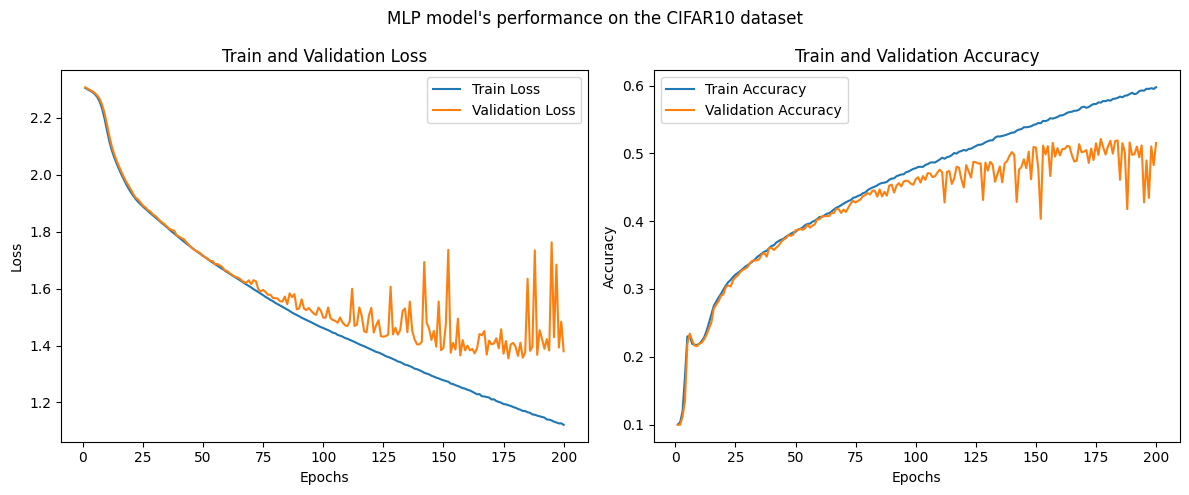

In [9]:
def plot_loss_acc(train_loss, val_loss, train_acc, val_acc, model_name):
  n_epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

  ax1.plot(range(1, n_epochs + 1), train_loss, label='Train Loss')
  ax1.plot(range(1, n_epochs + 1), val_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Train and Validation Loss')
  ax1.legend()

  ax2.plot(range(1, n_epochs + 1), train_acc, label='Train Accuracy')
  ax2.plot(range(1, n_epochs + 1), val_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Train and Validation Accuracy')
  ax2.legend()

  fig.suptitle(f"{model_name} model's performance on the CIFAR10 dataset")
  plt.tight_layout()
  plt.show()

plot_loss_acc(model_performance["train_loss_history"], model_performance["val_loss_history"], model_performance["train_acc_history"], model_performance["val_acc_history"], model_name="MLP")

In [10]:
# Prediction accuracy and confusion matrix on the test data
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
conf_matrix = np.zeros((10,10), dtype=np.int64)

with torch.no_grad():
  for inputs, labels in test_loader:
    y_hat, _, test_acc = batch_predict(model, inputs, labels)
    for i, x in enumerate(labels):
      conf_matrix[x, y_hat[i]] += 1

print(f"The prediction accuracy on the test dataset = {test_acc * 100: .2f} %")

The prediction accuracy on the test dataset =  47.90 %


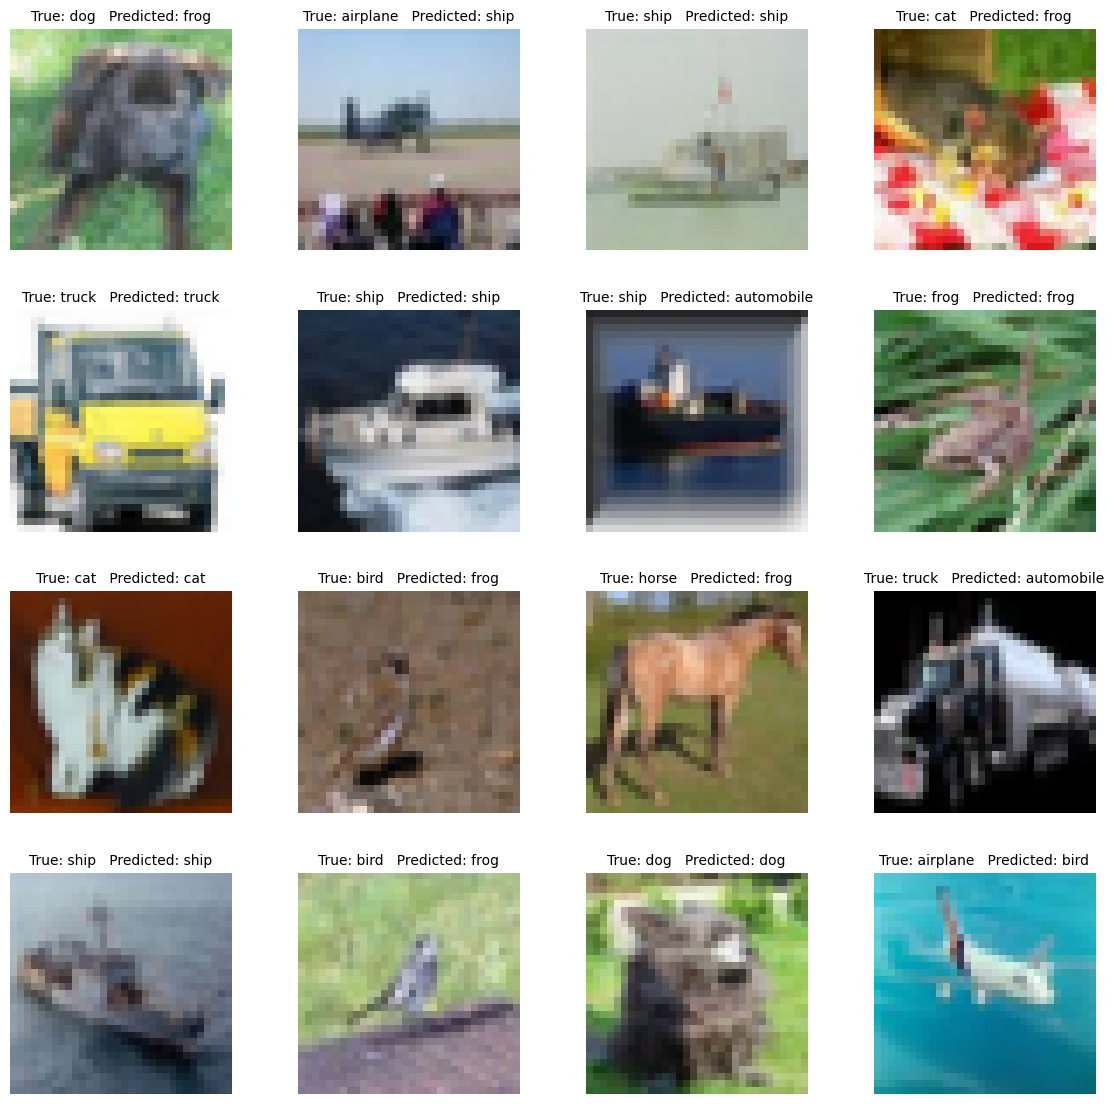

In [11]:
# Printing randomly selected images
num_samples = 16
shuffled_indices = torch.randperm(len(val_dataset))
selected_indices = shuffled_indices[:num_samples]
subset_dataset = torch.utils.data.Subset(val_dataset, selected_indices)
subset_loader = DataLoader(subset_dataset, batch_size=num_samples, shuffle=True)

for inputs, labels in subset_loader:
    y_hat, _, _ = batch_predict(model, inputs, labels)

    fig, axs = plt.subplots(4, 4, figsize=(14, 14))
    fig.subplots_adjust(wspace=0.3)

    for i in range(num_samples):
        axs[i // 4, i % 4].imshow(transforms.ToPILImage()(inputs[i]))
        axs[i // 4, i % 4].set_title(f"True: {val_dataset.classes[labels[i].item()]}   Predicted: {val_dataset.classes[y_hat[i].item()]}", fontsize=10)
        axs[i // 4, i % 4].axis('off')
    plt.show()


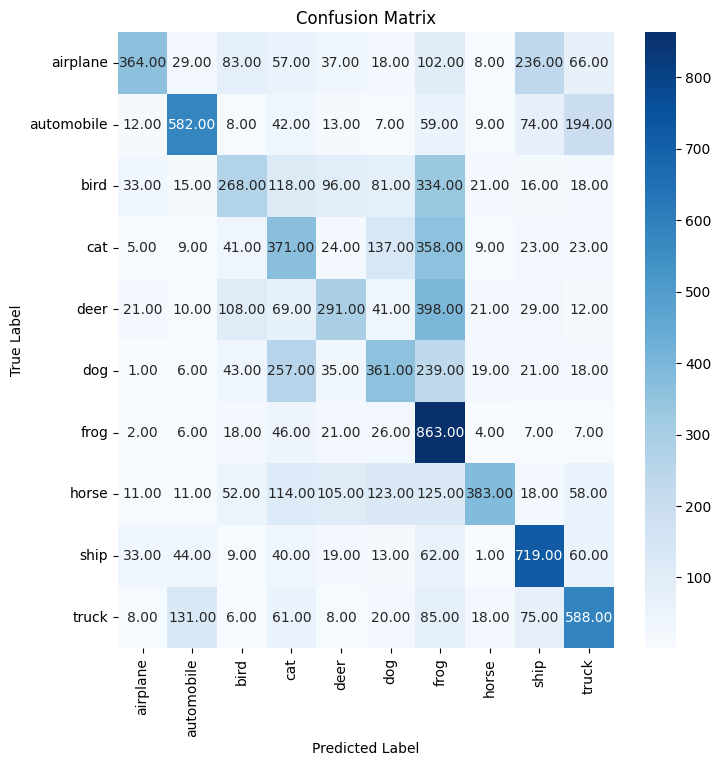

In [12]:
# Confusion Matrix on test predictions
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
# Repeating Exercise with Batch Normalization
n_epochs = 20
lr = 0.001

model, model_performance = model_trainer(MLPClassifier(input_size, output_size, with_bn=True).to(device), train_loader=train_loader, val_loader=val_loader, epochs=n_epochs, learning_rate=lr)
train_time = model_performance["training_time"]
print(f"Training is complete. It took {train_time:.4f} mins to train this network for {n_epochs} epochs")

Epoch 5/20, Train Loss: 1.5273, Val Loss: 1.5886, Time elapsed: 0.9278 mins
Epoch 10/20, Train Loss: 1.3092, Val Loss: 1.4351, Time elapsed: 1.7826 mins
Epoch 15/20, Train Loss: 1.1400, Val Loss: 1.3734, Time elapsed: 2.6532 mins
Epoch 20/20, Train Loss: 0.9892, Val Loss: 1.3592, Time elapsed: 3.5152 mins
Training is complete. It took 3.5152 mins to train this network for 20 epochs


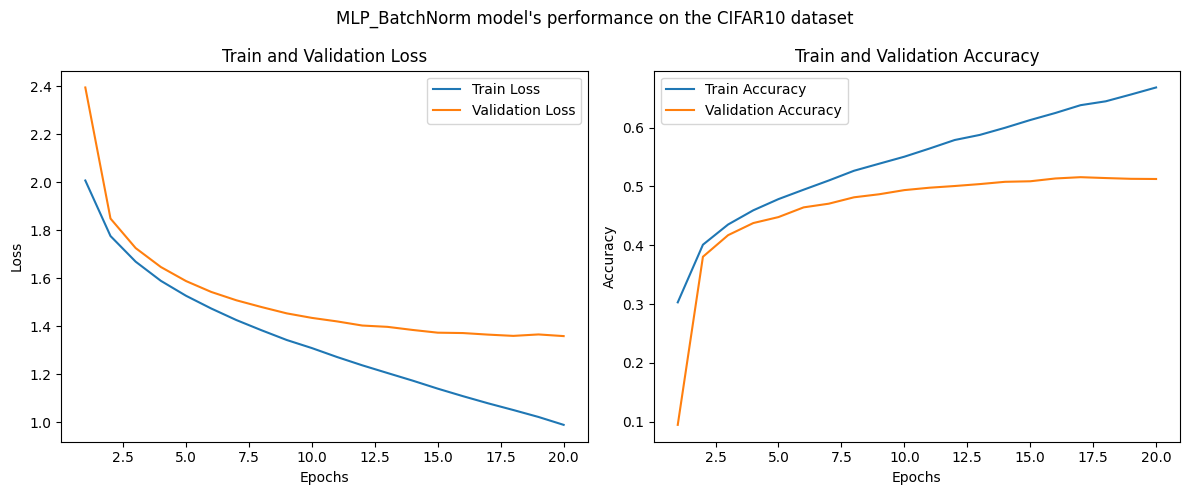

In [14]:
plot_loss_acc(model_performance["train_loss_history"], model_performance["val_loss_history"], model_performance["train_acc_history"], model_performance["val_acc_history"], model_name="MLP_BatchNorm")

In [15]:
# Prediction accuracy on test data
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

with torch.no_grad():
  for inputs, labels in test_loader:
    _, _, test_acc = batch_predict(model, inputs, labels)

print(f"The prediction accuracy on the test dataset with Batch Normalization = {test_acc * 100: .2f} %")

The prediction accuracy on the test dataset with Batch Normalization =  53.56 %
